## Training

In this notebook, we will carry out hyperparameter tuning to find a good Latent Dirichlet Allocation (LDA) model.

In [1]:
# imports
import numpy as np
import sys
sys.path.insert(0, "../")
from dataset import ArXivDataset
from model import TopicModel
from gensim.models import LdaModel, CoherenceModel
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns

sns.set_context("talk")
sns.set_style("ticks")
%config InlineBackend.figure_format="retina"

### Load dataset

While this notebook loads an already built and processed dataset of the 1A and 2A courses at CentraleSupelec

In [ ]:
# load dataset
dataset_path = "../object/dataset.obj"
dataset = ArXivDataset.load(dataset_path)
print("# courses: {s}".format(s=len(dataset)))

# courses: 286


In [ ]:
# set hyperparameters
number_of_topics = 300
num_topics_list = []
for i in range(1,number_of_topics):
    num_topics_list.append(i)
num_passes = 10
random_state = 929

Coherence Method c_npmi

segmentation -> probability calculation -> Confirmation measure -> aggregation

Segmentation: It uses the method S-one-set, that is, the confirmation measure will be computed over pairs of a word and the set W.

Probability Calculation: It uses the method Psw(110). The probabilities are calculated over a sliding window of size 110 that moves over the texts.

Confirmation Measure: It uses an indirect confirmation measure. The words of each pair’s elements are compared against all other words of W using the measure m_nlr. The final score is the cosine similarity between the two measures vectors.

Aggregation: The final coherence is the arithmetic mean of the confirmation measures.

In [ ]:
# run grid search
model_list = []
score_list = []
for num_topics in num_topics_list:
    model = LdaModel(corpus=dataset.corpus, id2word=dataset.idx2word,
                     num_topics=num_topics, passes=num_passes,
                     random_state=random_state, per_word_topics=True)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=dataset.documents,
                                     dictionary=dataset.idx2word, coherence="c_v")
    score = coherence_model.get_coherence()
    score_list.append(score)
    print(" * num_topics: {n:02d}\tscore: {s:.3f}".format(n=num_topics, s=score))   

 * num_topics: 01	score: 0.301
 * num_topics: 02	score: 0.315
 * num_topics: 03	score: 0.324
 * num_topics: 04	score: 0.337
 * num_topics: 05	score: 0.314
 * num_topics: 06	score: 0.334
 * num_topics: 07	score: 0.323
 * num_topics: 08	score: 0.332
 * num_topics: 09	score: 0.326
 * num_topics: 10	score: 0.329
 * num_topics: 11	score: 0.321
 * num_topics: 12	score: 0.318
 * num_topics: 13	score: 0.317
 * num_topics: 14	score: 0.318
 * num_topics: 15	score: 0.323
 * num_topics: 16	score: 0.331
 * num_topics: 17	score: 0.333
 * num_topics: 18	score: 0.311
 * num_topics: 19	score: 0.323
 * num_topics: 20	score: 0.344
 * num_topics: 21	score: 0.331
 * num_topics: 22	score: 0.329
 * num_topics: 23	score: 0.330
 * num_topics: 24	score: 0.331
 * num_topics: 25	score: 0.322
 * num_topics: 26	score: 0.323
 * num_topics: 27	score: 0.314
 * num_topics: 28	score: 0.326
 * num_topics: 29	score: 0.324
 * num_topics: 30	score: 0.333
 * num_topics: 31	score: 0.337
 * num_topics: 32	score: 0.339
 * num_t

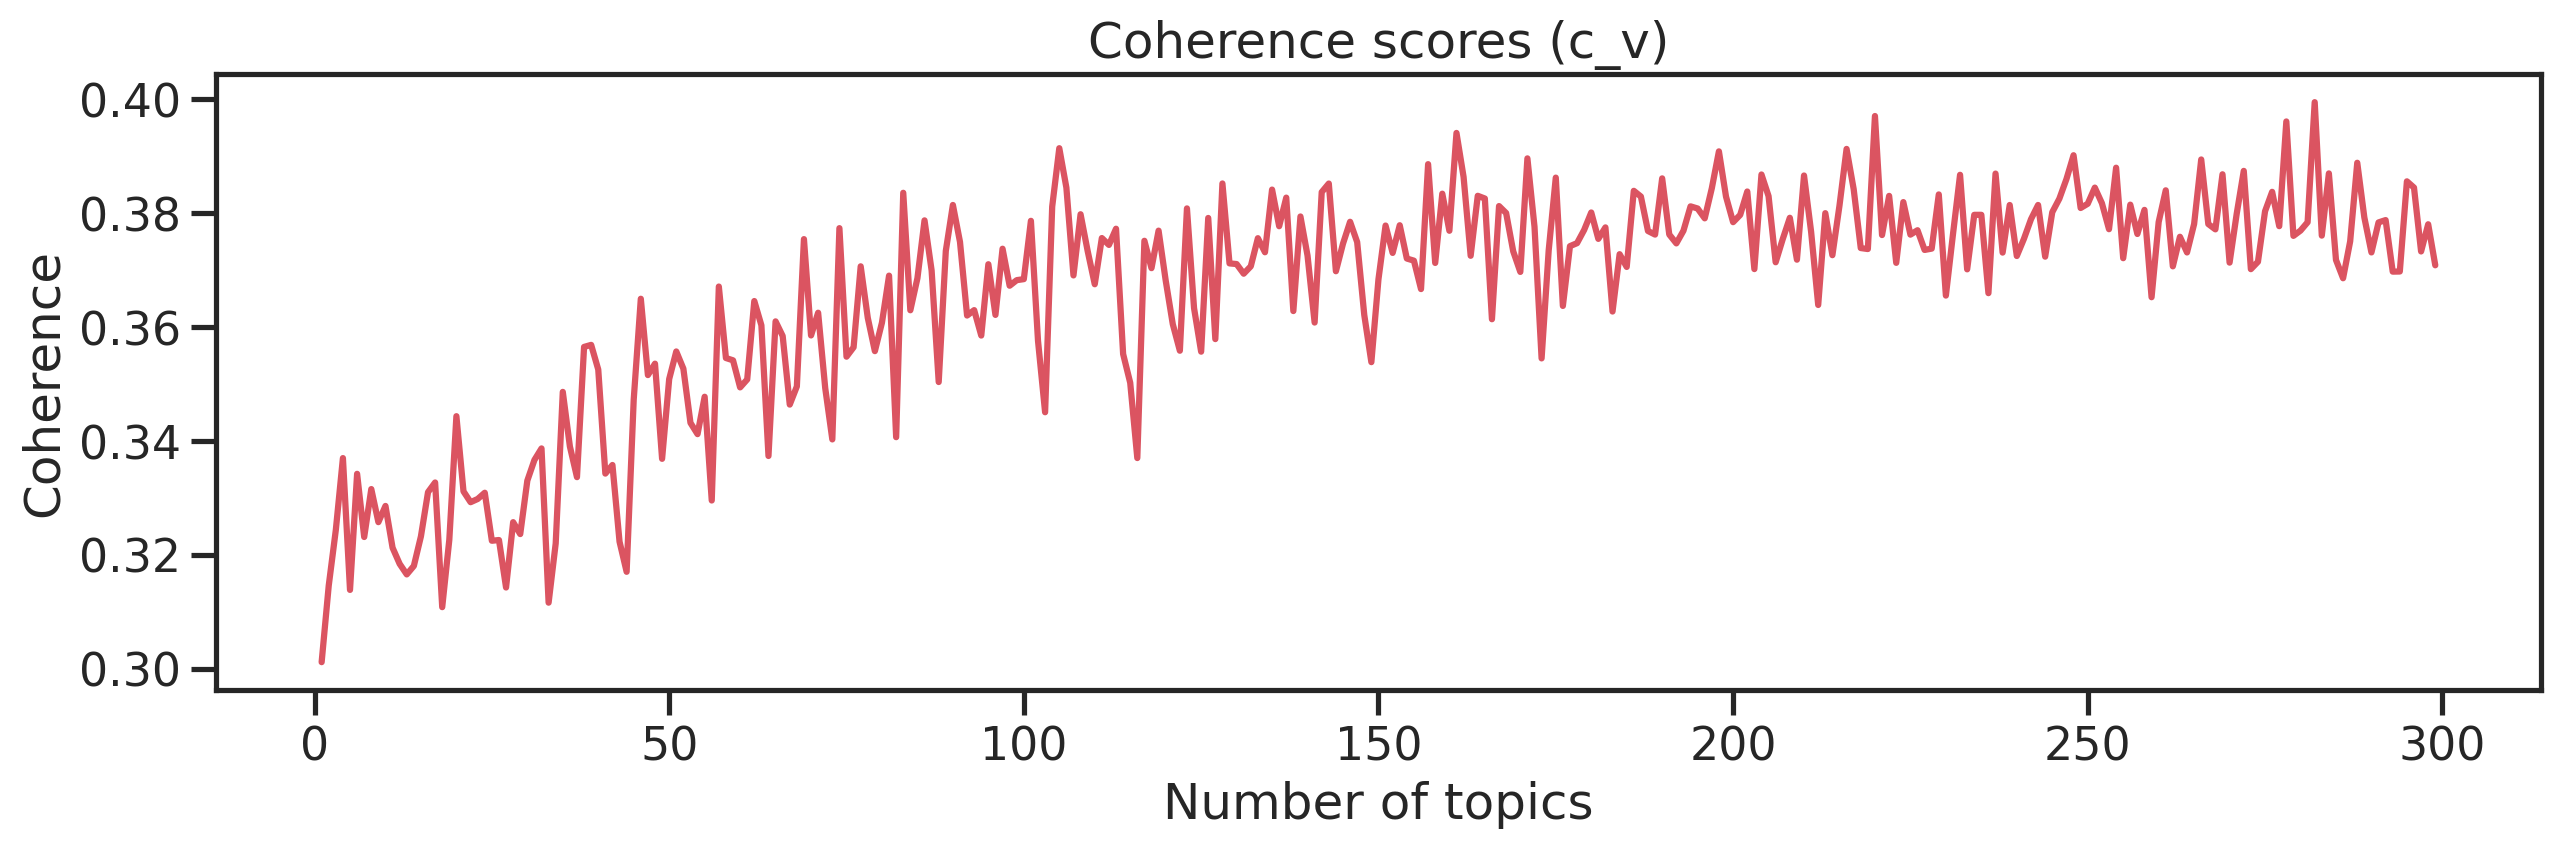

In [ ]:
# plot coherence scores
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.set_title("Coherence scores (c_v)")
sns.lineplot(x=num_topics_list, y=score_list, color="#DB5461", 
             ax=ax, legend=False)
ax.set_xlabel("Number of topics")
ax.set_ylabel("Coherence")
name = str(number_of_topics) + "coherencescores.png"
plt.savefig("../data/plots/" + name,format="png", dpi=300)
plt.show()


From the above plot, it can be observed that setting the number of topics to be 12 would be optimal.

### Exporting the best model

Now that we have identified the best model, we can export it for inference in the future.

In [ ]:
# export best model
best_idx = np.argmax(score_list)
best_model = model_list[best_idx]
best_score = score_list[best_idx]
num_topics = num_topics_list[best_idx]
best_model_path = "../models/lda_n{n}_p{p}_r{r}_c{c}".format(n=num_topics, p=num_passes,
                                                            r=random_state,
                                                            c=str(round(best_score * 100, 1)))
best_model.save(best_model_path)
print("Model saved to {path}".format(path=best_model_path))

Model saved to ../models/lda_n282_p10_r929_c39.9


In [ ]:
# create topic model
model_path = best_model_path
dataset_path = "../object/dataset.obj"
model = TopicModel(model_path, dataset_path)

In [ ]:
# print topics
pprint(model.topics)

[(0,
  [('concept', 0.00041366793),
   ('wave', 0.00039718987),
   ('analysis', 0.00036187383),
   ('lecture', 0.00035840867),
   ('tutorial', 0.00032146546),
   ('theoretical', 0.00031410265),
   ('field', 0.0002537968),
   ('result', 0.0002519904),
   ('system', 0.0002517456),
   ('description', 0.00025043322)]),
 (1,
  [('system', 0.07378551),
   ('case', 0.016499598),
   ('battery', 0.014249655),
   ('class', 0.013115601),
   ('onera', 0.011663093),
   ('approach', 0.01146925),
   ('modelling', 0.011410819),
   ('management', 0.011362366),
   ('challenge', 0.010306093),
   ('complex', 0.010041945)]),
 (2,
  [('marketing', 0.08687936),
   ('digital', 0.046618674),
   ('transformation', 0.03379753),
   ('strategy', 0.01923656),
   ('company', 0.013760005),
   ('de_rennes', 0.009522301),
   ('impact', 0.009338561),
   ('la', 0.009317427),
   ('des', 0.009283904),
   ('new', 0.009280235)]),
 (3,
  [('issue', 0.00013666833),
   ('research', 0.0001344797),
   ('ethic', 0.00013228299),
  